In [271]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import naturalneighbor as nn
import dask
from datetime import datetime
from scipy.ndimage import convolve
dask.config.set(scheduler = "single-threaded")

In [272]:
# Load data sets
# --------------------------------------

ds1 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpdlprofwind4newsC1.c1.*.nc',   combine='by_coords', parallel = True)
ds2 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpco2flxwindC1.b1.*.nc',        combine='by_coords', parallel = True)
ds3 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpinterpolatedsondeC1.c1.*.nc', combine='by_coords', parallel = True)
ds4 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpmawsC1.b1.*.nc',              combine='by_coords', parallel = True)

In [273]:
# Get reference dates from each data set
# --------------------------------------

ref_date1 = np.datetime64(datetime(pd.to_datetime(ds1.time[0].values).year, pd.to_datetime(ds1.time[0].values).month, pd.to_datetime(ds1.time[0].values).day))
ref_date2 = np.datetime64(datetime(pd.to_datetime(ds2.time[0].values).year, pd.to_datetime(ds2.time[0].values).month, pd.to_datetime(ds2.time[0].values).day))
ref_date3 = np.datetime64(datetime(pd.to_datetime(ds3.time[0].values).year, pd.to_datetime(ds3.time[0].values).month, pd.to_datetime(ds3.time[0].values).day))
ref_date4 = np.datetime64(datetime(pd.to_datetime(ds4.time[0].values).year, pd.to_datetime(ds4.time[0].values).month, pd.to_datetime(ds4.time[0].values).day))

In [274]:
# Ensure reference dates match
# --------------------------------------

assert(ref_date1 == ref_date2)
assert(ref_date1 == ref_date3)
assert(ref_date1 == ref_date4)

In [275]:
# Compute new time axis
# --------------------------------------

ds1['time'] = ((ds1.time - ref_date1) / np.timedelta64(1, 'D')).values
ds2['time'] = ((ds2.time - ref_date2) / np.timedelta64(1, 'D')).values
ds3['time'] = ((ds3.time - ref_date3) / np.timedelta64(1, 'D')).values
ds4['time'] = ((ds4.time - ref_date4) / np.timedelta64(1, 'D')).values

In [276]:
# Get interpolation values
# --------------------------------------

min_date = max([ds1['time'][0],  ds2['time'][0],  ds3['time'][0],  ds4['time'][0]])
max_date = min([ds1['time'][-1], ds2['time'][-1], ds3['time'][-1], ds4['time'][-1]])

interval = (1/4)/24

common_time = np.arange(min_date, max_date, interval)

In [277]:
# Regularize data sets
# --------------------------------------

ds1 = ds1.interp(time = common_time)
ds2 = ds2.interp(time = common_time)
ds3 = ds3.interp(time = common_time, height = 3000)
# ds4 = ds4.interp(time = common_time)

# ds_combined = xr.concat([ds2, ds1, ds3, ds4], dim = 'height')
ds_combined = xr.concat([ds2, ds1, ds3], dim = 'height')
ds_combined = ds_combined.sortby('height')

ds_combined = ds_combined.transpose()
old_u = ds_combined['u'].values
old_v = ds_combined['v'].values

heights     = np.linspace(4, 2000, 200)
old_heights = ds_combined['height'].values
new_u       = np.zeros((len(heights), ds_combined['u'].shape[1]))
new_v       = np.zeros((len(heights), ds_combined['v'].shape[1]))

for t in range(new_u.shape[1]):
    inds       = ~np.isnan(old_u[:, t])
    new_u[:,t] = np.interp(heights, old_heights[inds], old_u[inds, t])
    new_v[:,t] = np.interp(heights, old_heights[inds], old_v[inds, t])

qc_flag = np.zeros(common_time.shape)

total_h = len(old_heights)

for t in range(common_time.shape[0]):
    qc_flag[t] = np.sum(np.isnan(old_u[:, t])) / total_h

qc_flag = qc_flag < 1/2

del ds1
del ds2
del ds3
del old_u
del old_v

ds_new = xr.Dataset({
'u': xr.DataArray(
            data   = new_u[:, qc_flag],   # enter data here
            dims   = ['height', 'time'],
            coords = {'height': heights, 'time': common_time[qc_flag]},
),
'v': xr.DataArray(
            data   = new_v[:, qc_flag],   # enter data here
            dims   = ['height', 'time'],
            coords = {'height': heights, 'time': common_time[qc_flag]},
),
    })

del ds_combined
del new_u
del new_v

(0.0, 2000.0)

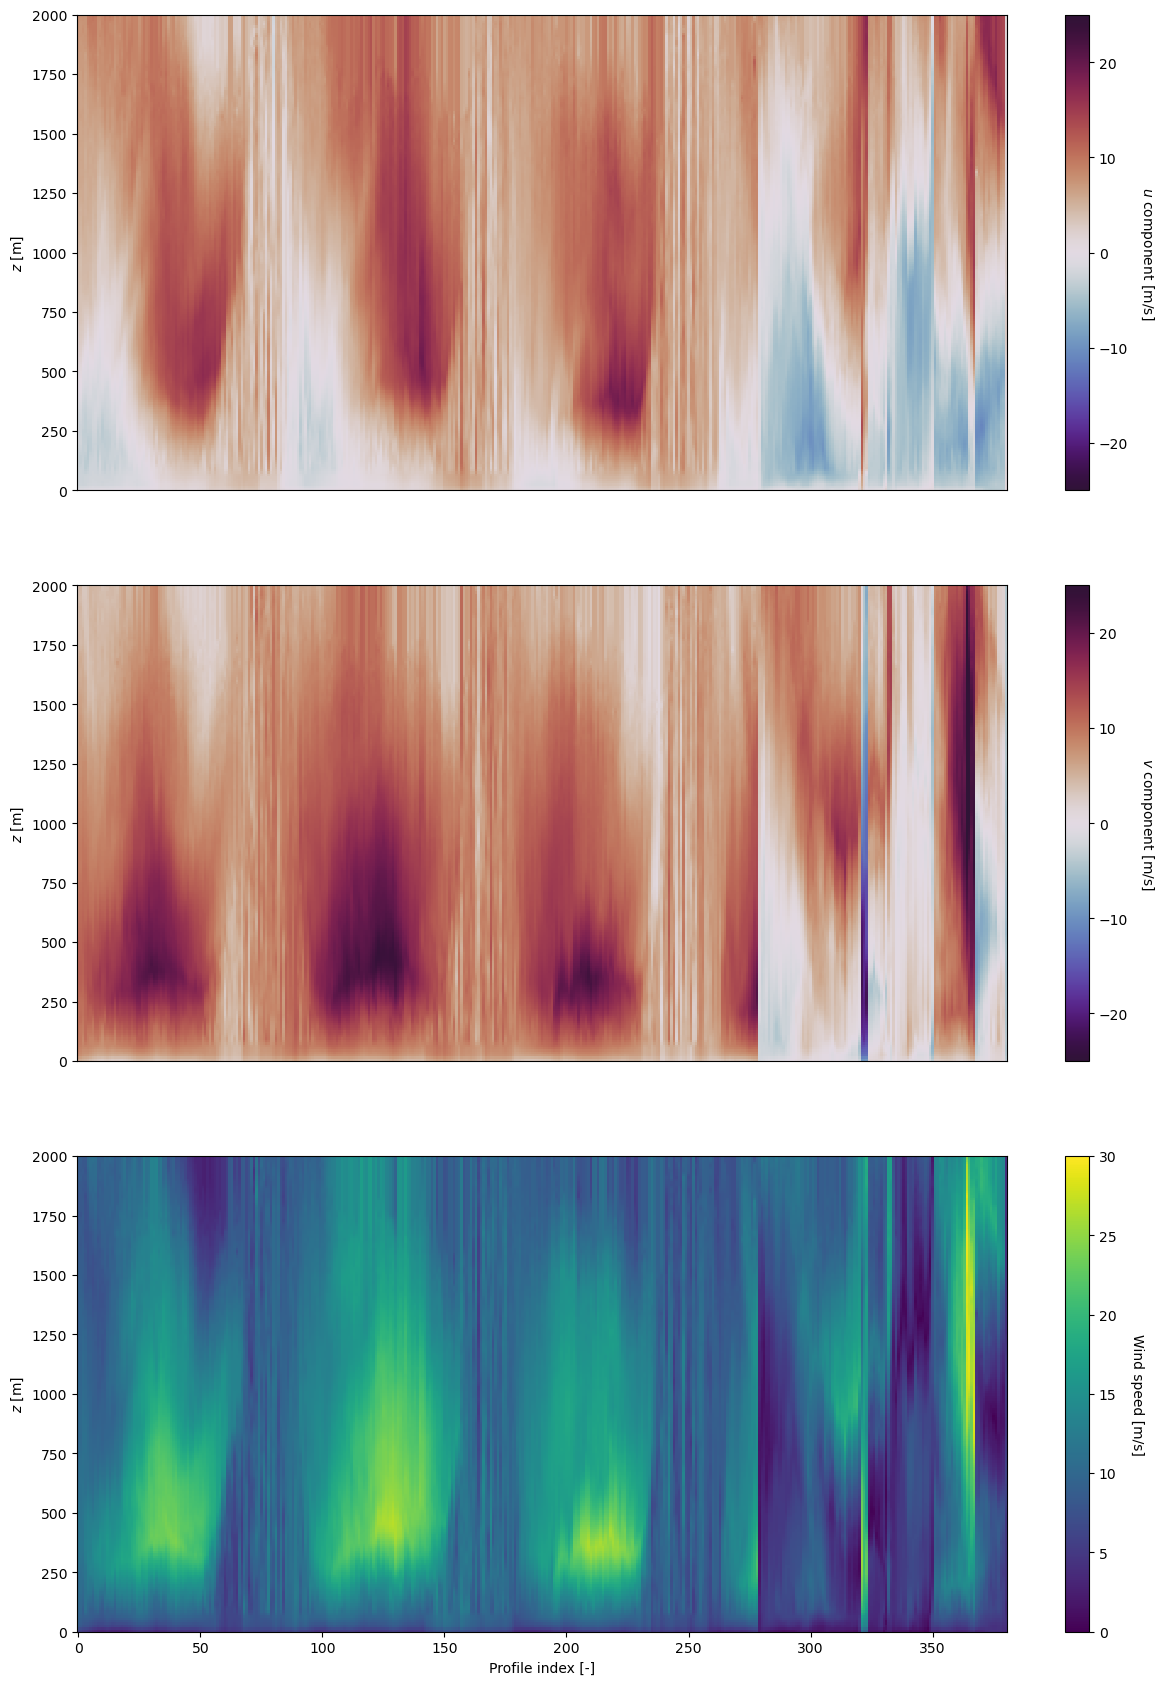

In [278]:
# Plot rectified data
# --------------------------------------

fig,ax = plt.subplots(3, 1, figsize = (15, 21))

cntf = ax[0].pcolormesh(range(len(ds_new.time)), ds_new.height, ds_new.u, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 20)
ax[0].set_ylabel("$z$ [m]")
ax[0].set_ylim([0, 2000])
ax[0].get_xaxis().set_ticks([])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

cntf = ax[1].pcolormesh(range(len(ds_new.time)), ds_new.height, ds_new.v, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 20)
ax[1].set_ylabel("$z$ [m]")
ax[1].set_ylim([0, 2000])
ax[1].get_xaxis().set_ticks([])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

cntf = ax[2].pcolormesh(range(len(ds_new.time)), ds_new.height, (ds_new.v**2 + ds_new.u**2)**(1/2), vmin = 0, vmax = 30, cmap = 'viridis')
cbar = plt.colorbar(cntf)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
ax[2].set_xlabel("Profile index [-]")
ax[2].set_ylabel("$z$ [m]")
ax[2].set_ylim([0, 2000])
# plt.xlim([datetime.date(2023, 8, 1), datetime.date(2023, 8, 2)])

Text(0.5, 1.0, 'Days from reference: 2.25')

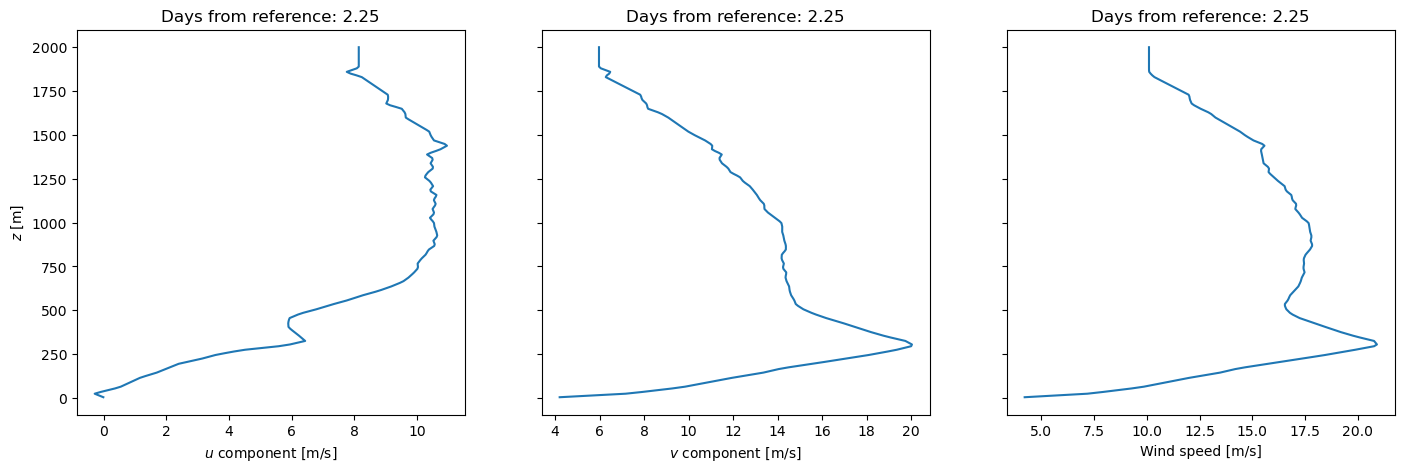

In [279]:
# Plot sample component profiles
# --------------------------------------

fig,ax = plt.subplots(1,3,figsize = (17, 5), sharey = True)

i = 200

ax[0].plot(ds_new.u[:,i], ds_new.height)
ax[0].set_xlabel('$u$ component [m/s]')
ax[0].set_ylabel('$z$ [m]')
# ax[0].set_ylim([0, 50])
ax[0].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

ax[1].plot(ds_new.v[:,i], ds_new.height)
ax[1].set_xlabel('$v$ component [m/s]')
# ax[1].set_ylabel('$z$ [m]')
# ax[1].set_ylim([0, 50])
ax[1].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

ax[2].plot((ds_new.u[:,i]**2 + ds_new.v[:,i]**2)**(1/2), ds_new.height)
ax[2].set_xlabel('Wind speed [m/s]')
# ax[2].set_ylabel('$z$ [m]')
# ax.set_ylim([0, 50])
ax[2].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

In [280]:
# Compute common time axis and cyclical time variables
# --------------------------------------

new_ref_times = np.empty(ds_new.time.shape, dtype = 'datetime64[ns]')
hr_per_day    = np.zeros(new_ref_times.shape)
day_per_yr    = np.zeros(new_ref_times.shape)
times         = ds_new.time.values

for i in range(ds_new.time.shape[0]):
    new_ref_times[i] = np.datetime64(pd.Timestamp(ref_date1) + pd.Timedelta(times[i], 'D'))
    hr_per_day[i]    = pd.Timestamp(new_ref_times[i]).hour
    day_per_yr[i]    = new_ref_times[i].astype('datetime64[D]').astype(datetime).timetuple().tm_yday

Text(0, 0.5, 'Day of year')

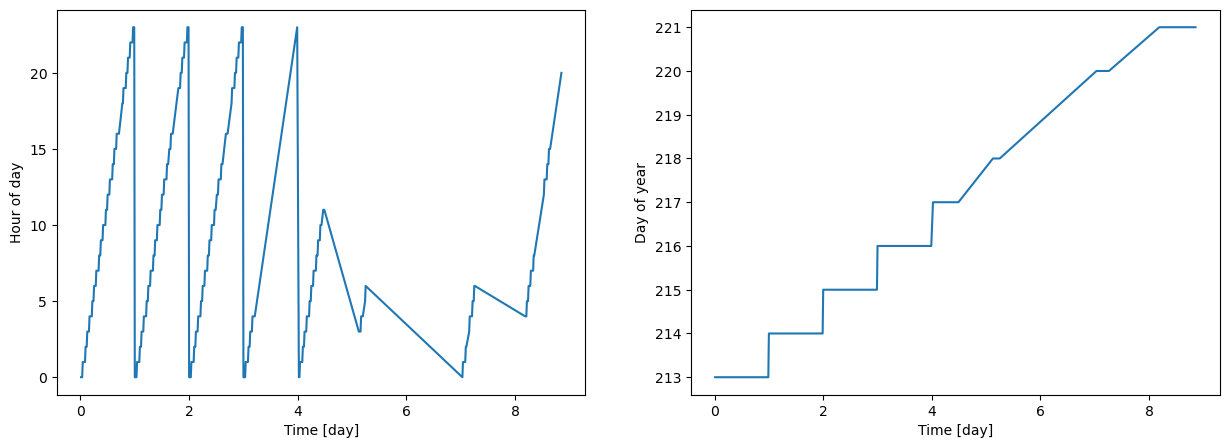

In [281]:
# Confirm time axes are correct
# --------------------------------------

fig,ax = plt.subplots(1,2,figsize = (15, 5))

ax[0].plot(times, hr_per_day)
# ax[0].plot(range(len(times)), hr_per_day)
ax[0].set_xlabel('Time [day]')
ax[0].set_ylabel('Hour of day')

ax[1].plot(times, day_per_yr)
# ax[1].plot(range(len(times)), day_per_yr)
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel('Day of year')

In [282]:
# Save data
# --------------------------------------

ds_new['hr_day'] = (('time'), hr_per_day)
ds_new['day_yr'] = (('time'), day_per_yr)

ds_new.to_netcdf('/Users/smata/Downloads/processedData/velocityData.nc')

ds_new

<xarray.Dataset>
Dimensions:  (height: 200, time: 381)
Coordinates:
  * height   (height) float64 4.0 14.03 24.06 34.09 ... 1.98e+03 1.99e+03 2e+03
  * time     (time) float64 0.01042 0.02083 0.03125 ... 8.635 8.646 8.854
Data variables:
    u        (height, time) float64 -1.223 -1.304 -1.385 ... 14.5 13.98 1.382
    v        (height, time) float64 5.906 5.474 5.042 ... 2.334 1.926 -3.958
    hr_day   (time) float64 0.0 0.0 0.0 1.0 1.0 1.0 ... 14.0 15.0 15.0 15.0 20.0
    day_yr   (time) float64 213.0 213.0 213.0 213.0 ... 221.0 221.0 221.0 221.0